# Link Prediction

In [ ]:
import json
import networkx as nx
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import scripts.degree as degree
sns.set(style='darkgrid')

In [ ]:
# Load data

edge_df = pd.read_csv("data/edges.csv", delimiter=",")
node_df = pd.read_csv("data/nodes.csv", delimiter=",")


In [ ]:
# Turn into networkx graph

G = nx.from_pandas_edgelist(edge_df, source="# source", target=" target", create_using=nx.Graph())

#nx.number_of_edges(G)

nx.number_of_nodes(G)


5242

In [ ]:
largest_cc = max(nx.connected_components(G), key=len)
LG = G.subgraph(largest_cc)

KeyboardInterrupt: 

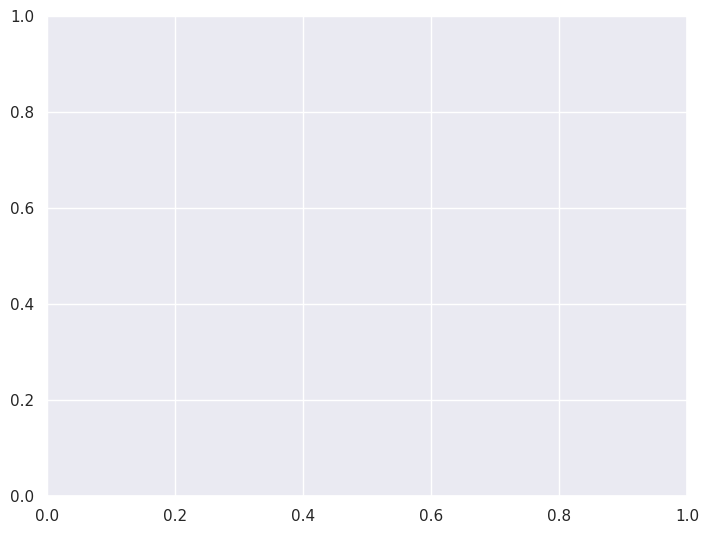

In [ ]:
nx.draw(LG, node_size=1)

### Preferential Attachment

In [ ]:
#%%script echo Skipping!
# We define a function called pref_attachment
def pref_attachment(graph, n):
    scores = []
    track = [] # a list to keep track of all the nodes and their score for later use
    # We use the preferential attachment documentation from networkx
    linkpred_pa = list(nx.preferential_attachment(graph))
    # Now we sort in decreasing score
    linkpred_pa.sort(key = lambda tup: tup[2], reverse = True)
    # We make a for-loop for the link predictions between the nodes
    for u, v, p in linkpred_pa[:n]:
        # We normalize the scores using the G.number_of_nodes
        score = p * (1 / (2 * graph.number_of_nodes()))
        scores.append(score)
        print(f"({u}, {v}) -> {score:.3f}")
        track.append(((u,v), score)) # append the nodes as tuple and score as float

    plt.title("Preferential attachment")
    plt.xlabel("Score")
    plt.ylabel("Number of nodes")
    plt.hist(scores, bins=50)
    plt.show()
    return scores, track
    
# We run the function and save the list of scores
#scores, track = pref_attachment(LG, LG.number_of_nodes())

The result we get is the score of possible edges between nodes that don't have that specific edge between them. SO the bigger the degree of a certain node is, the higher the possibility of an edge appearing between those two nodes. 

In [ ]:
track

[((21012, 15244), 0.5746753246753247),
 ((21281, 15244), 0.5604858104858105),
 ((12365, 15244), 0.5462962962962963),
 ((22691, 15244), 0.5462962962962963),
 ((9785, 15244), 0.48244348244348245),
 ((6610, 15244), 0.48244348244348245),
 ((21012, 6512), 0.4772727272727273),
 ((21508, 15244), 0.47534872534872535),
 ((17655, 15244), 0.46825396825396826),
 ((21281, 6512), 0.4654882154882155),
 ((2741, 15244), 0.46115921115921116),
 ((12365, 6512), 0.4537037037037037),
 ((22691, 6512), 0.4537037037037037),
 ((19423, 15244), 0.44696969696969696),
 ((15003, 15244), 0.4398749398749399),
 ((21012, 13801), 0.4383116883116883),
 ((21012, 13929), 0.4383116883116883),
 ((21281, 13801), 0.42748917748917753),
 ((21281, 13929), 0.42748917748917753),
 ((14807, 15244), 0.4256854256854257),
 ((10350, 21012), 0.41883116883116883),
 ((18866, 21281), 0.417989417989418),
 ((12365, 13801), 0.4166666666666667),
 ((12365, 13929), 0.4166666666666667),
 ((4511, 22691), 0.4166666666666667),
 ((13801, 22691), 0.41666

In [ ]:
# Looking at the highest probability, aka the first element in the list

# see if it adds up

node_u = track[0][0][0] # the first node (u). 21012, degree 81
node_v = track[0][0][1] # the second node (v).   15244

node_list_degrees = pd.read_csv("data/node_list_degrees.csv")

u_idx = np.where(node_list_degrees["Node_id"]==node_u)
v_idx = np.where(node_list_degrees["Node_id"]==node_v)

v_idx = v_idx[0][0]
u_idx = u_idx[0][0]

# the degrees of node u and v
u_degree = node_list_degrees['Degree'][u_idx]
v_degree = node_list_degrees['Degree'][v_idx]

# PA(x,y) = |N(x)| * |N(y)| where N(u) is the set of nodes adjacent to u.
# so x's degree * y's degree * (1/num nodes)  to normalise

u_degree * v_degree * (1/(2*len(LG.nodes)))




0.5746753246753247

So, the highest score in the Preferential Attachment, is node 21012 and node 15244. They have a probability of 0.5746 of connecting if a random edge was added in the graph.

Their degree is: node 21012: degree  81 ------ node 15244: degree: 59

### Adamic Adar

In [ ]:
%%script echo Skipping!
ef adamic_adar(graph, top_n):
    scores = []
    linkpred_aa = list(nx.adamic_adar_index(graph))
    # Sort in decreasing score
    linkpred_aa.sort(key = lambda tup: tup[2], reverse = True)
    for u, v, p in linkpred_aa[:top_n]:
        scores.append(p)
        print(f"({u}, {v}) -> {p:.8f}")


    plt.title("Adamic-Adar", loc = 'left')
    plt.xlabel("Score")
    plt.ylabel("Number of nodes")
    plt.hist(scores, bins=50)
    plt.show()

adamic_adar(G, G.number_of_nodes())

Skipping!


In Adamic-Adar (AA) we say that common neighbors are important, but the hubs contribute less to the link prediction than two common neighbors with no other links, because the hubs do not have enough bandwidth to make the introduction
The formula says that, for each common neighbor, instead of counting one – as we do in Common Neighbor when we look at the intersection –, we count one over the common neighbor’s degree (log-transformed).

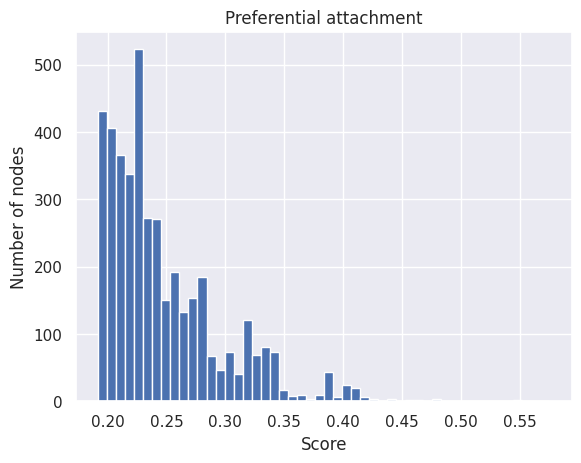

In [ ]:
link_pred(graph = LG, formula = "pref", n = LG.number_of_nodes(), plot = True)

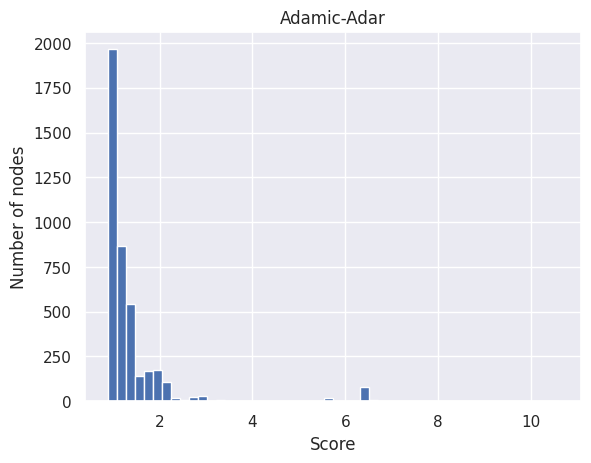

In [ ]:
link_pred(graph = LG, formula = "adamic", n = LG.number_of_nodes(), plot = True)

In [ ]:
link_pred(graph = Astro, formula = "pref", n = Astro.number_of_nodes())

NameError: name 'link_pred' is not defined


In Adamic-Adar (AA) we say that common neighbors are important, but the hubs contribute less to the link prediction than two common neighbors with no other links, because the hubs do not have enough bandwidth to make the introduction
The formula says that, for each common neighbor, instead of counting one – as we do in Common Neighbor when we look at the intersection –, we count one over the common neighbor’s degree (log-transformed).

In [ ]:
# from main
%%script echo Skipping!
def adamic_adar(graph, top_n):
    linkpred_aa = list(nx.adamic_adar_index(graph))
    # Sort in decreasing score
    linkpred_aa.sort(key = lambda tup: tup[2], reverse = True)
    for u, v, p in linkpred_aa[:top_n]:
        print(f"({u}, {v}) -> {p:.8f}")

    plt.hist(p, bins=50)
    plt.show()

adamic_adar(G, 5)

# Link-Prediction Comparisons

In [ ]:
# load the data 
Astro_edge_df = pd.read_csv("other_datasets/AstroPh/edges.csv", delimiter=",")
Astro_node_df = pd.read_csv("other_datasets/AstroPh/nodes.csv", delimiter=",")

# load the data 
Cond_edge_df = pd.read_csv("other_datasets/CondMat/edges.csv", delimiter=",")
Cond_node_df = pd.read_csv("other_datasets/CondMat/nodes.csv", delimiter=",")

# load the data 
HPH_edge_df = pd.read_csv("other_datasets/HepPh/edges.csv", delimiter=",")
HPH_node_df = pd.read_csv("other_datasets/HepPh/nodes.csv", delimiter=",")

# load the data 
HTH_edge_df = pd.read_csv("other_datasets/HepTh/edges.csv", delimiter=",")
HTH_node_df = pd.read_csv("other_datasets/HepTh/nodes.csv", delimiter=",")



# generate graphs
G1 = nx.from_pandas_edgelist(Astro_edge_df, source="# source", target=" target", create_using=nx.Graph())
G2 = nx.from_pandas_edgelist(Cond_edge_df, source="# source", target=" target", create_using=nx.Graph())
G3 = nx.from_pandas_edgelist(HPH_edge_df, source="# source", target=" target", create_using=nx.Graph())
G4 = nx.from_pandas_edgelist(HTH_edge_df, source="# source", target=" target", create_using=nx.Graph())

# only focus on the giant hub in the middle
largest_cc1 = max(nx.connected_components(G1), key=len)
largest_cc2 = max(nx.connected_components(G2), key=len)
largest_cc3 = max(nx.connected_components(G3), key=len)
largest_cc4 = max(nx.connected_components(G4), key=len)

# generate smaller graph
Astro = G1.subgraph(largest_cc1)
Cond = G2.subgraph(largest_cc2)
HPh = G3.subgraph(largest_cc3)
HTh = G4.subgraph(largest_cc4)



**AstroPh:**

Astro-Physics. 

Number of nodes: 17.903

Number of edges: 197.031

**CondMat:**

Condensed Matter. 

Number of nodes: 21.363

Number of edges: 91.342

**HepPh:**

High Energy Physics Phenomenology. 

Number of nodes: 11.204

Number of edges: 117.649

**HepTh:**

High Energy Physics Theory. 

Number of nodes: 8638

Number of edges: 24.827

## Preferential Attachment Comparison

### AstroPhysics

In [ ]:
#link_pred(graph = Astro, formula = "pref", n = Astro.number_of_nodes(), plot = True)

### Condensed Matter

In [ ]:
#link_pred(graph = Cond, formula = "pref", n = Cond.number_of_nodes(), plot = True)

### High Energy Physics Phenomenology

In [ ]:
#link_pred(graph = HPh, formula = "pref", n = HPh.number_of_nodes(), plot = True)

### High Energy Physics Theory

In [ ]:
#link_pred(graph = HTh, formula = "pref", n = HTh.number_of_nodes(), plot = True)

(14726, 26122) -> 0.068
(14726, 26398) -> 0.068
(14726, 47542) -> 0.068
(14726, 15618) -> 0.068
(47542, 54915) -> 0.068
(47542, 55319) -> 0.068
(47542, 59471) -> 0.068
(47542, 63697) -> 0.068
(47542, 65168) -> 0.068
(15618, 54915) -> 0.068
(15618, 55319) -> 0.068
(15618, 59471) -> 0.068
(15618, 63697) -> 0.068
(15618, 65168) -> 0.068
(18433, 59471) -> 0.068
(18433, 54915) -> 0.068
(18433, 55319) -> 0.068
(18433, 63697) -> 0.068
(18433, 65168) -> 0.068
(51294, 59471) -> 0.068
(51294, 54915) -> 0.068
(51294, 55319) -> 0.068
(51294, 63697) -> 0.068
(51294, 65168) -> 0.068
(51840, 59471) -> 0.068
(51840, 54915) -> 0.068
(51840, 55319) -> 0.068
(51840, 63697) -> 0.068
(51840, 65168) -> 0.068
(19470, 59471) -> 0.068
(19470, 54915) -> 0.068
(19470, 55319) -> 0.068
(19470, 63697) -> 0.068
(19470, 65168) -> 0.068
(53450, 59471) -> 0.068
(53450, 54915) -> 0.068
(53450, 55319) -> 0.068
(53450, 63697) -> 0.068
(53450, 65168) -> 0.068
(21669, 59471) -> 0.068
(21669, 54915) -> 0.068
(21669, 55319) -

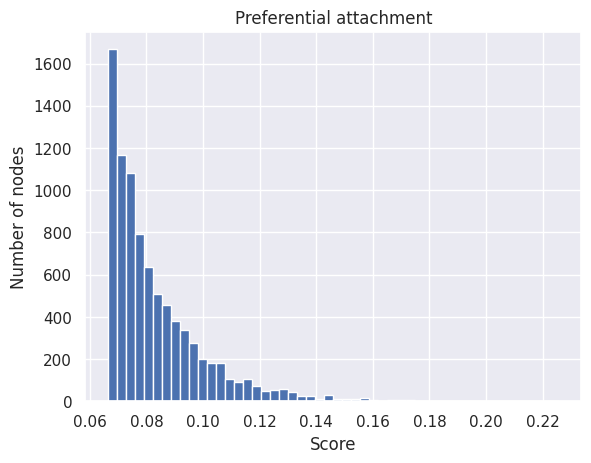

In [ ]:
scores, track = pref_attachment(HTh, HTh.number_of_nodes())

# Random Graph Albert

### Make graph

In [ ]:
from networkx.generators import barabasi_albert_graph

n = LG.number_of_nodes()
m = 3
PALG = barabasi_albert_graph(n=n,m=m, seed=1)
print("edges",PALG.number_of_edges(),"nodes", PALG.number_of_nodes())

edges 12465 nodes 4158


### Summary 

In [ ]:
from scripts.summary import final_return_statement as summary
summary(PALG, 5)

KeyboardInterrupt: 

In [ ]:
nx.to_pandas_edgelist(PALG).to_csv("data/PA_graph_1.csv", index=False)

### Degree Distribution - Power Law 

/shared-libs/python3.8/py/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1041: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


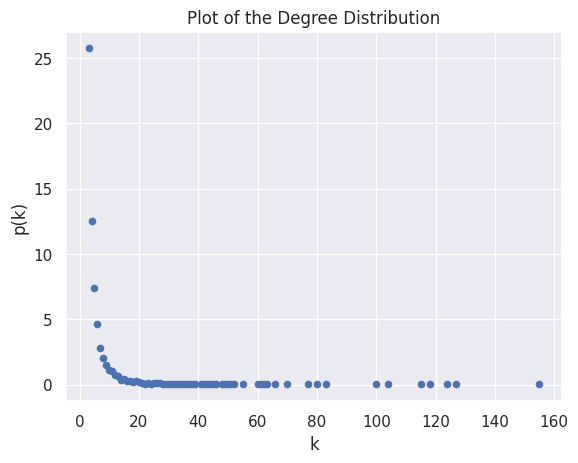

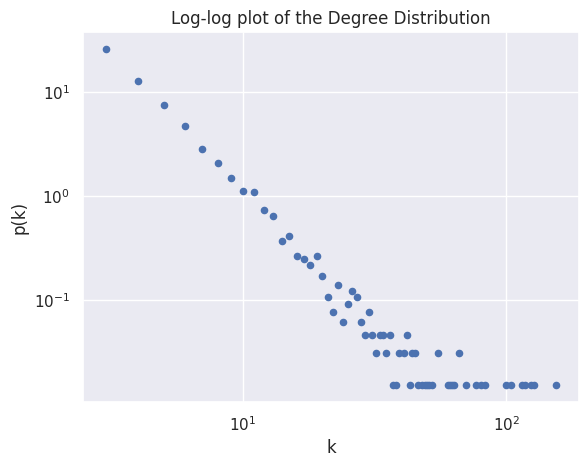

In [ ]:
node_dfCC = pd.DataFrame(sorted(dict(nx.degree(PALG)).items()))
node_dfCC.rename(columns={0:"Node_id",1:"Degree"}, inplace=True)
node_dfCC.to_csv("data/node_list_degreesPALG.csv", index=False)

node_list_degrees = pd.read_csv("data/node_list_degreesPALG.csv")

df_degrees = degree.make_df(node_list_degrees)

degree.plot_degree(df_degrees)

degree.plot_degree_log(df_degrees)

CCDF Fit: 9.8775 x ^ -1.9337 (R2 = 0.9924, p = 0.0000)


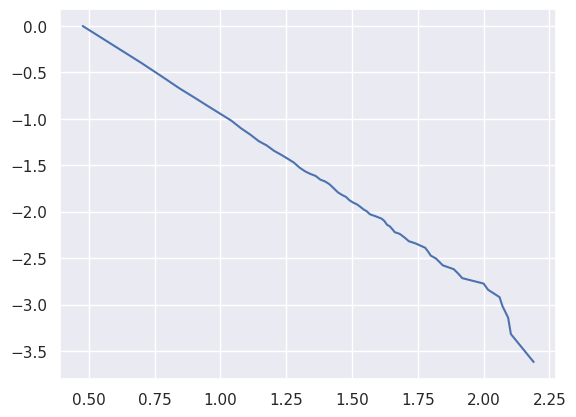

Calculating best minimal value for power law fit
Powerlaw CCDF Fit: 10.9552 x ^ -1.7097 (k_min = 30)
(0.21362968620159994, 0.00024050024050024048, 1.002199711725042)
1.7096941898774882
Compare: (9.353764129288598, 0.09006772450540679)


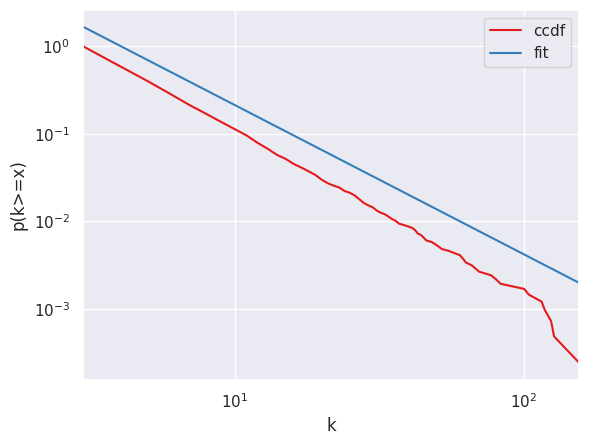

In [ ]:
degree.check_power_law(PALG)

### Path Length Distribution 

In [ ]:
'''
There are V*(V-1) shortest paths to compute - a lot. So i save it in a json file,
such that we don't need to run the algorithm every time. 
'''
path_lengthsPALG = dict(nx.all_pairs_shortest_path_length(PALG))

json_path_lengthsPALG = json.dumps(path_lengthsPALG)

#open file for writing, "w" 
f = open("path_lengthsPALG.json","w")

# write json object to file
f.write(json_path_lengthsPALG)

# close file
f.close()

In [ ]:
with open('data/path_lengthsPALG.json', 'r') as f:
  data = json.load(f)

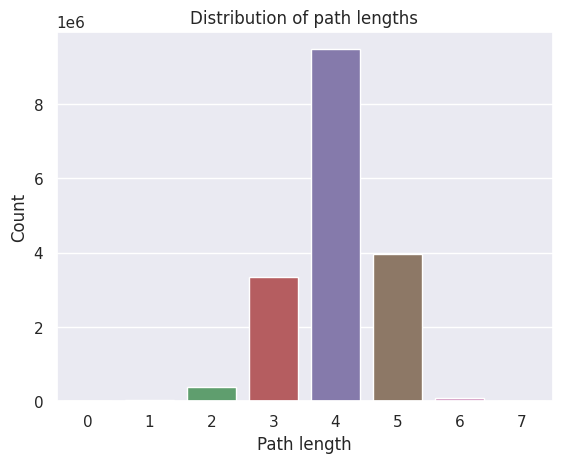

In [ ]:
# Helper function to get all values of a nested dictionary 
def NestedDictValues(d):
  for v in d.values():
    if isinstance(v, dict):
      yield from NestedDictValues(v)
    else:
      yield v

path_lengths = list(NestedDictValues(data)) # now we have a list of all path lengths 
count_len = Counter(path_lengths) # Counter dict. Key(path length): value(count)

# Lets plot the result - using barplot since we already have the counts. 
g = sns.barplot(x=list(count_len.keys()), y=list(count_len.values()))
g.set(title='Distribution of path lengths', xlabel="Path length", ylabel="Count");

# NOTICE; The counts on the y-axis is in terms of y-axis multiplied by 10^6 

In [ ]:
nx.degree_assortativity_coefficient(LG), nx.degree_assortativity_coefficient(PALG)

(0.6389971399620687, -0.0421589290872953)

In [ ]:
degrees = dict(PALG.degree())


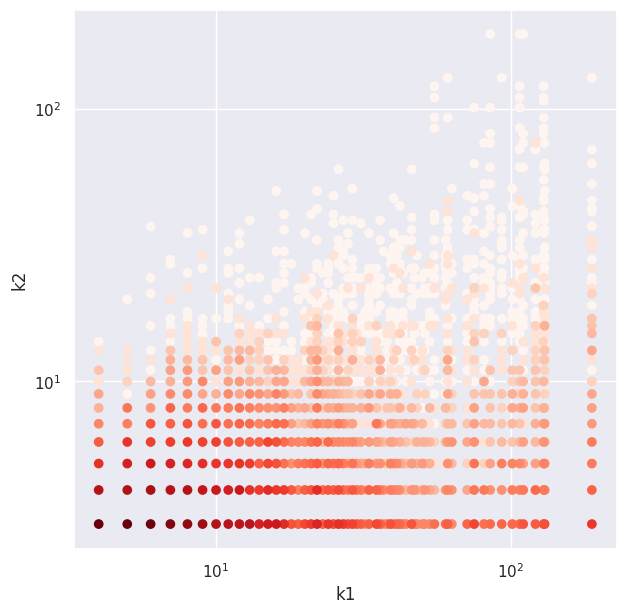

In [ ]:

# Edge-centric plot 
edge_assort = [(degrees[e[0]], degrees[e[1]]) for e in PALG.edges] 
edge_assort = pd.DataFrame(data = edge_assort, columns = ("k1", "k2")) 
edge_assort = edge_assort.groupby(by = ["k1", "k2"]).size().reset_index().rename(columns = {0: "count"}).sort_values(by = "count")
# Taking the log count of edges with nodes with the same degrees
edge_assort["log_count"] = np.log(edge_assort["count"])
fig, ax = plt.subplots(figsize=(7,7))
plt.scatter(edge_assort["k1"], edge_assort["k2"], c = edge_assort["log_count"], cmap = "Reds")
#plt.scatter(edge_assort["k1"], edge_assort["k2"], c = edge_assort["count"], cmap = "Reds")
ax.set(yscale="log",xscale="log", xlabel="k1", ylabel="k2")
#ax.set(yscale="linear",xscale="linear", xlabel="k1", ylabel="k2")
plt.show()

In [ ]:
# Node-centric plot
node_assort = [(degrees[n], degrees[n2]) for n in G.nodes for n2 in G.neighbors(n)]
node_assort = pd.DataFrame(data = node_assort, columns = ("k", "neigh_k"))
node_assort = node_assort.groupby(by = "k").mean().reset_index()

# Plotting the node-centric plot
ax = plt.gca()
plt.scatter(node_assort["k"], node_assort["neigh_k"])
ax.set_yscale("log")
ax.set_xscale("log")
plt.show()

KeyError: 7596

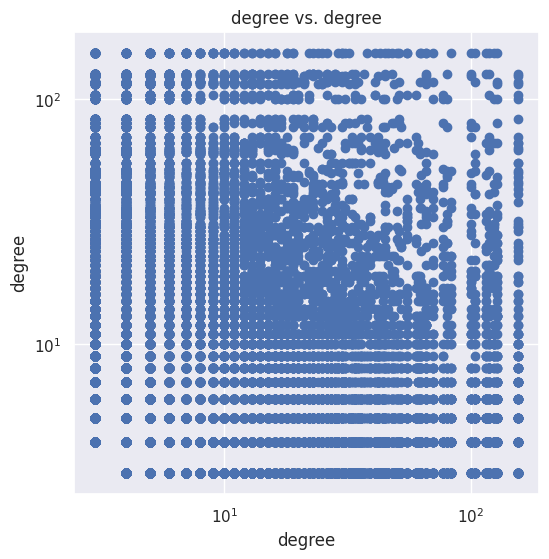

In [ ]:
test = [(PALG.degree(n), PALG.degree(n2)) for n in PALG.nodes for n2 in PALG.neighbors(n)]
test1 = [i[0] for i in test]
test2 = [i[1] for i in test]
fig, ax = plt.subplots(figsize=(6,6))
ax.set(xlabel="degree", ylabel="degree", title="degree vs. degree")
ax.set(yscale="log",xscale="log")
plt.scatter(test1, test2)
plt.show()